Comparison between two settings of Mimic model:

1. Orca settings: the reward is inspired by Orca paper. State and reward are normalized. Normalization processing follows a standardization of all kernel variables. Reward is normalized w.r.t. the maximum bandiwidth estimated so far. Throughput is measured using the number of delivered packets.
2. Owl settings: the reward is inspired by Owl paper. State and reward are not normalized. The reward is sensitive to the bandwidth of the specific cellular trace. Throughput is measured using cwnd (sending rate).

In [2]:
import os
import sys
sys.path.insert(0, os.path.abspath(os.path.join('', os.pardir)))
analysis_dir = os.path.abspath(os.path.join('', os.pardir))
sys.path.insert(0, os.path.abspath(os.path.join(analysis_dir, os.pardir)))
from utils.misc import read_json_file
from src.ml.helper.utils import parse_traces_config

analysis_dir = os.path.abspath(os.path.join('', os.pardir))
root_dir = os.path.abspath(os.path.join(analysis_dir, os.pardir))
path_to_plot_dir = "/home/lorenzo/Desktop/mimic-2/analysis/plots/thruput_vs_rtt"

ml_dir: /home/lorenzo/Desktop/mimic-2/src/ml | src_dir: /home/lorenzo/Desktop/mimic-2/src | entry_dir: /home/lorenzo/Desktop/mimic-2 




In [3]:
# Latest Mimic experiments with owl settings
policy = "bootstrapped_ucb"
model_owl = f"{policy}.2023.04.04.04.04.57"
model_orca = f"{policy}.2023.04.19.09.08.39"

In [4]:
# Read trace names and paths from YAML file
trace_data = parse_traces_config()
traces = [t for t in trace_data['traces'].keys()]
traces

['att.lte.driving',
 'att.lte.driving.2016',
 'tm.lte.driving',
 'tm.lte.short',
 'tm.umts.driving',
 'vz.evdo.driving',
 'vz.lte.driving',
 'vz.lte.short',
 'bus',
 'timessquare',
 'wired']

In [35]:
# Get iperf logs path for each model-trace pair

# Select policy
log_dir_path = os.path.join(root_dir, 'log')
mab_dir_path = os.path.join(log_dir_path, 'mab', 'config')
config_file_name = policy + '.json'
file_path = os.path.join(mab_dir_path, config_file_name)
config = read_json_file(file_path)
n_runs = 5

# Get iperf timestamp (latest 5 runs for each model if any)
trace_dict = {}
for t in traces:
    for model in [model_owl, model_orca]:
        trace_dict[(model, t)] = []
        relevant_traces = [trace for trace in config['traces'] if trace['model_name'] == model and trace['trace_name'].startswith(t)]
        if t == 'att.lte.driving':
            relevant_traces = [trace for trace in relevant_traces if '2016' not in trace["trace_name"]]
        relevant_traces = sorted(relevant_traces, key=lambda x: x['timestamp'], reverse=True)
        for i in range(min(len(relevant_traces), n_runs)):
            latest_trace = relevant_traces[i]
            filename = latest_trace['trace_name'].replace('.csv', '.json')
            trace_dict[(model, t)].append(os.path.join(root_dir, "log", "iperf", filename))

In [36]:
trace_dict

{('bootstrapped_ucb.2023.04.04.04.04.57',
  'att.lte.driving'): ['/home/lorenzo/Desktop/mimic-2/log/iperf/att.lte.driving.bootstrapped_ucb.2023.04.05.22.22.11.json'],
 ('bootstrapped_ucb.2023.04.19.09.08.39',
  'att.lte.driving'): ['/home/lorenzo/Desktop/mimic-2/log/iperf/att.lte.driving.bootstrapped_ucb.2023.04.20.15.26.03.json', '/home/lorenzo/Desktop/mimic-2/log/iperf/att.lte.driving.bootstrapped_ucb.2023.04.20.15.25.31.json', '/home/lorenzo/Desktop/mimic-2/log/iperf/att.lte.driving.bootstrapped_ucb.2023.04.20.15.22.57.json', '/home/lorenzo/Desktop/mimic-2/log/iperf/att.lte.driving.bootstrapped_ucb.2023.04.20.15.11.02.json', '/home/lorenzo/Desktop/mimic-2/log/iperf/att.lte.driving.bootstrapped_ucb.2023.04.20.09.31.16.json'],
 ('bootstrapped_ucb.2023.04.04.04.04.57',
  'att.lte.driving.2016'): ['/home/lorenzo/Desktop/mimic-2/log/iperf/att.lte.driving.2016.bootstrapped_ucb.2023.04.05.22.23.17.json'],
 ('bootstrapped_ucb.2023.04.19.09.08.39',
  'att.lte.driving.2016'): ['/home/lorenzo/

In [22]:
from collections import defaultdict

# Group entries by trace key
grouped_dict_owl, grouped_dict_orca =  defaultdict(list),  defaultdict(list)
for key, value in trace_dict.items():
    trace_key = key[1]
    if key[0] == model_owl:
        grouped_dict_owl[trace_key].append(value)
    else:
        grouped_dict_orca[trace_key].append(value)

In [39]:
grouped_dict_owl['att.lte.driving'][0]

['/home/lorenzo/Desktop/mimic-2/log/iperf/att.lte.driving.2016.bootstrapped_ucb.2023.04.05.22.23.17.json',
 '/home/lorenzo/Desktop/mimic-2/log/iperf/att.lte.driving.bootstrapped_ucb.2023.04.05.22.22.11.json']

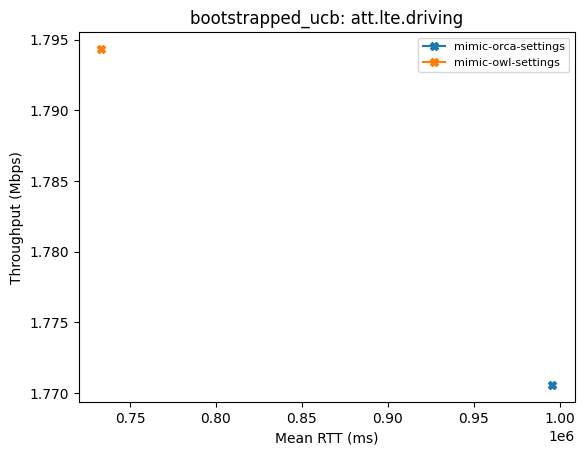

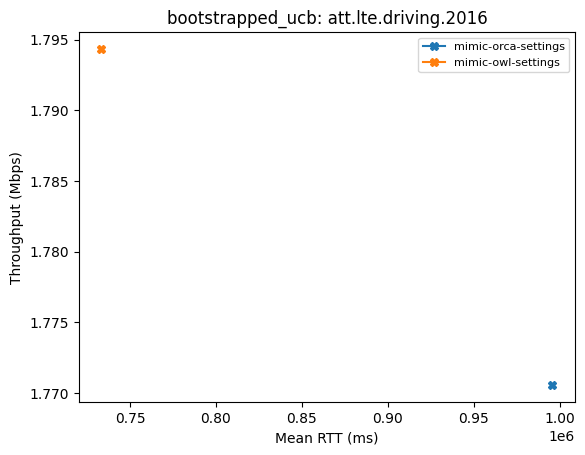

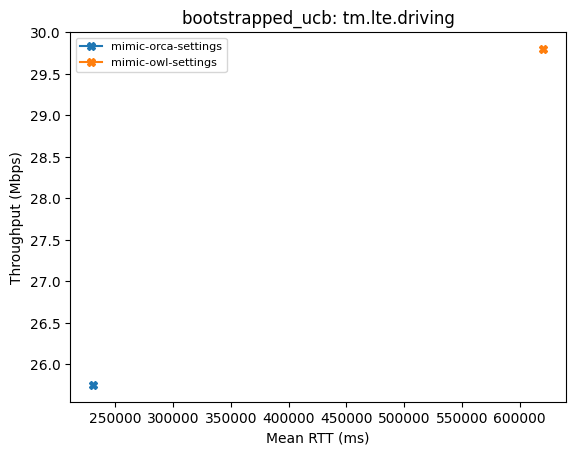

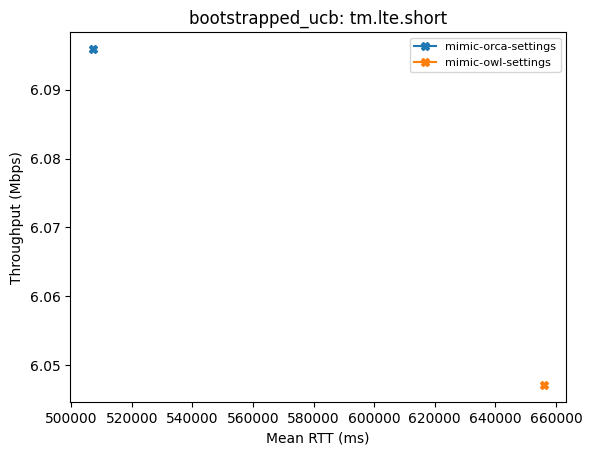

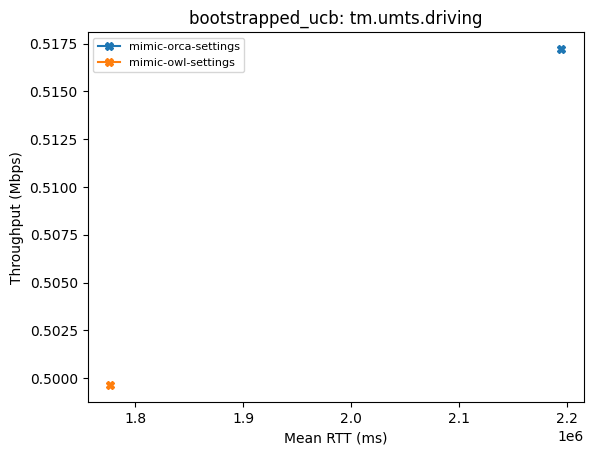

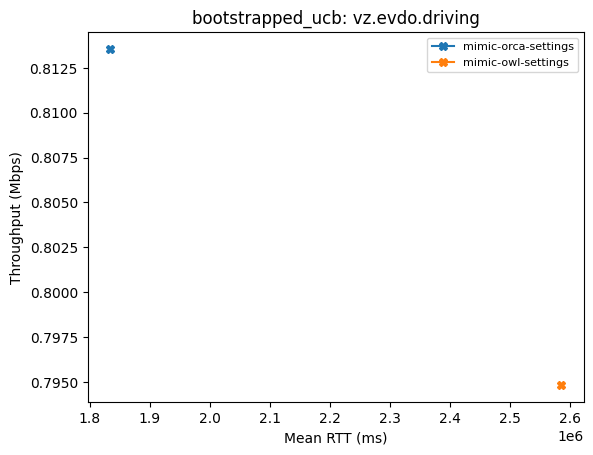

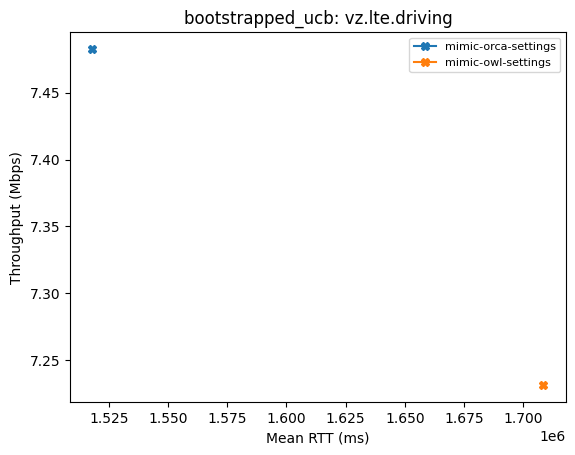

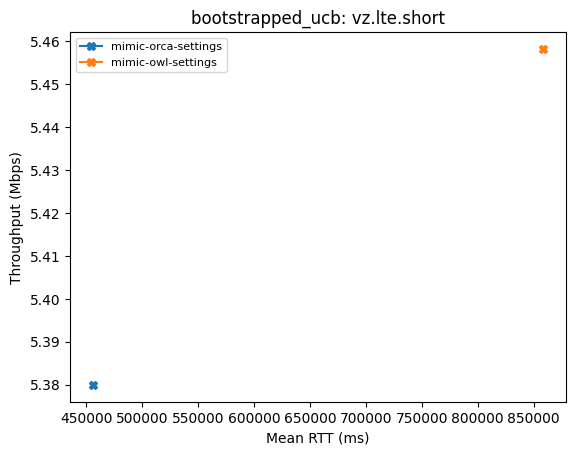

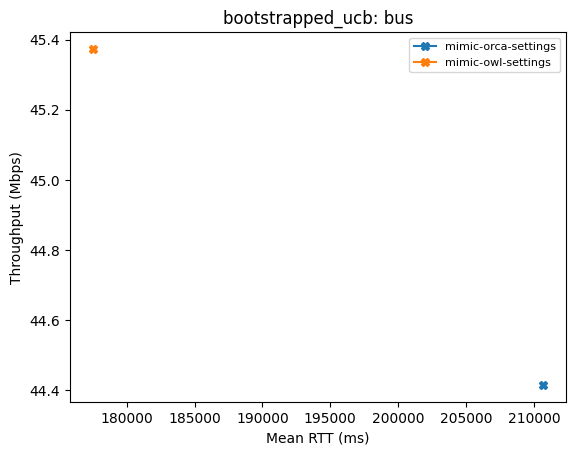

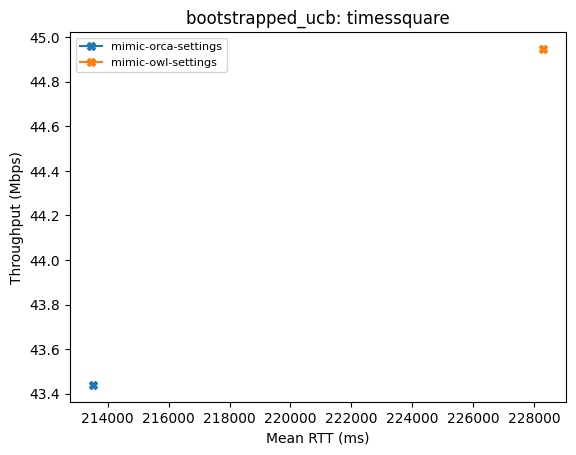

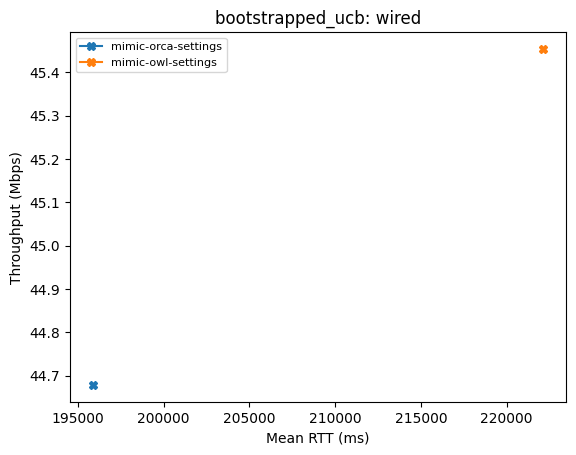

In [36]:
save = True
import matplotlib.pyplot as plt

for trace in traces:
    # Get mimic config for owl and orca settings
    mimic_orca_set = read_json_file(grouped_dict_orca[trace][0][0])
    mimic_owl_set = read_json_file(grouped_dict_owl[trace][0][0])

    # Get metrics
    mimic_orca_metrics_rcv = mimic_orca_set['end']['streams'][0]['receiver']
    mimic_owl_metrics_rcv = mimic_owl_set['end']['streams'][0]['receiver']

    mimic_orca_sender = mimic_orca_set['end']['streams'][0]['sender']
    mimic_owl_sender = mimic_owl_set['end']['streams'][0]['sender']

    #  Get latency
    mimic_orca_mean_rtt = mimic_orca_sender['mean_rtt']
    mimic_owl_mean_rtt = mimic_owl_sender['mean_rtt']

    #  Get thruput
    mimic_orca_thruput = mimic_orca_metrics_rcv['bits_per_second']*10**(-6)
    mimic_owl_thruput = mimic_owl_metrics_rcv['bits_per_second']*10**(-6)

    # Plot
    fig, ax = plt.subplots()
    ax.plot(mimic_orca_mean_rtt, mimic_orca_thruput, marker='X', label=f'mimic-orca-settings')
    ax.plot(mimic_owl_mean_rtt, mimic_owl_thruput, marker='X', label='mimic-owl-settings')


    # set axis labels and legend
    ax.set_title(f"{policy}: {trace}")
    ax.set_xlabel('Mean RTT (ms)', fontsize=10)
    ax.set_ylabel('Throughput (Mbps)', fontsize=10)
    ax.legend(fontsize=8)

    if save:
        filename = f"mab.orca_vs_owl_settings.{policy}.{trace}.thruput_vs_rtt.png"
        plt.savefig(os.path.join(path_to_plot_dir, filename))

    # show plot
    plt.show()
